In [2]:
### Define Chain(s)

from niagara import Chain, Model, ModelIntrinsicLogProb, NullTransformation, LogisticRegressionCalibrator
from niagara import OpenAIClient, FireworksClient

llama_chain = Chain(
    models = [
        Model(
            model_name=name, 
            thresholds={"reject": -10000, "accept": 0.0},
            conf_signal=ModelIntrinsicLogProb(),
            conf_signal_transform=NullTransformation(),
            conf_signal_calibrator=LogisticRegressionCalibrator()
        )
        for name in ["llama3.2-1b", "llama3.2-3b", "llama3.1-8b", "llama3.1-70b", "llama3.1-405b"]
    ]
)

qwen_oai_chain = Chain(
    models = [
        Model(
            model_name=name, 
            thresholds={"reject": -10000, "accept": 0.0},
            conf_signal=ModelIntrinsicLogProb(),
            conf_signal_transform=NullTransformation(),
            conf_signal_calibrator=LogisticRegressionCalibrator(),
            client=client
        )
        for name, client in [("gpt-4o-mini", OpenAIClient()), ("qwen2.5-32b-coder-instruct", FireworksClient()), ("qwen2.5-72b-instruct", FireworksClient()), ("gpt-4o", OpenAIClient())]
    ]
)

In [3]:
### Select chain, benchmark, transformation, and grab data

import pickle
from niagara import OneSidedAsymptoticLog, TwoSidedAsymptoticLog

PRETTY_NAMES = {
    "xsum": "XSum",
    "mmlu": "MMLU",
    "medmcqa": "MedMCQA",
    "triviaqa": "TriviaQA",
    "truthfulqa": "TruthfulQA",
    "gsm8k": "GSM8K"
}

NAME = "medmcqa"
TRANSFORM = OneSidedAsymptoticLog()
CHAIN_NAME = "qwen_oai_chain"
CHAIN = qwen_oai_chain

# Update the transformation for the chain
for model in CHAIN.models:
    model.conf_signal_transform = TRANSFORM

with open(f'../benchmarks/data/{NAME}/chain_results/{NAME}_full_{CHAIN_NAME}_results_train.pkl', 'rb') as f:
    results_train = pickle.load(f)
with open(f'../benchmarks/data/{NAME}/chain_results/{NAME}_full_{CHAIN_NAME}_results_test.pkl', 'rb') as f:
    results_test = pickle.load(f)

In [ ]:
### Compute calibrated confidence values

process_scores = lambda scores: sum(scores.values()) >= 20

if NAME=="xsum":
    raw_corr_train = { k: [process_scores(x) for x in v] for k,v in results_train['model_correctness'].items() }
else:
    raw_corr_train= results_train['model_correctness']

raw_conf_train = results_train['raw_confidences']

corr_train = [
    raw_corr_train[model_name] for model_name in CHAIN.model_names
]

transformed_conf_train = [ 
    list(TRANSFORM.transform_confidence_signal(raw_conf_train[model_name]))
        for model_name in CHAIN.model_names
]

calibration_data = [
    {"correctness": corr, "transformed_confidence": conf} 
        for (corr, conf, model_name) 
            in zip(corr_train, transformed_conf_train, CHAIN.model_names)
]

CHAIN.calibrate(calibration_data)

calibrated_conf_train = [
    list(
        CHAIN.models[model_idx].conf_signal_calibrator.calibrate_confidence_signal(
            transformed_conf_train[model_idx]
        )
    )
    for model_idx in range(len(CHAIN.model_names))
]

In [ ]:
### Compute test data

if NAME=="xsum":
    raw_corr_test = { k: [process_scores(x) for x in v] for k,v in results_test['model_correctness'].items() }
else:
    raw_corr_test= results_test['model_correctness']

raw_conf_test = results_test['raw_confidences']

corr_test = [
    raw_corr_test[model_name] for model_name in CHAIN.model_names
]

transformed_conf_test = [ 
    list(TRANSFORM.transform_confidence_signal(raw_conf_test[model_name]))
        for model_name in CHAIN.model_names
]

calibrated_conf_test = [
    list(
        CHAIN.models[model_idx].conf_signal_calibrator.calibrate_confidence_signal(
            transformed_conf_test[model_idx]
        )
    )
    for model_idx in range(len(CHAIN.model_names))
]

In [77]:
from statsmodels.distributions.empirical_distribution import ECDF
from tqdm import tqdm
import numpy as np

# Compute Cramer von Mises statistic
def compute_cvm(F_emp, F_null, n_grid=1000):
    integration_grid = np.linspace(0, 1, n_grid)
    integrand = [ (F_emp(v) - F_null(v))**2 for v in integration_grid ]
    sum_1 = np.sum(integrand[1:] * np.diff(F_null(integration_grid)))
    sum_2 = np.sum(integrand[:-1] * np.diff(F_null(integration_grid)))
    integral = (sum_1 + sum_2) / 2
    return integral

# Compute Cramer von Mises pval
def compute_cvm_pval(test_statistic, null_dist, n_obs, B=1000):
    cvm_statistic_list = []
    for b in tqdm(range(B)):
        null_sample_b = null_dist.rvs(size=n_obs)
        null_empirical_cdf_b = ECDF(null_sample_b)
        cvm_statistic_b = compute_cvm(null_empirical_cdf_b, null_dist.cdf, n_grid=1000)
        cvm_statistic_list.append(cvm_statistic_b)

    # Compute p value
    pval = np.mean(np.array(cvm_statistic_list) >= test_statistic)
    return pval, cvm_statistic_list

Converged at iteration 646
Converged at iteration 821


100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]


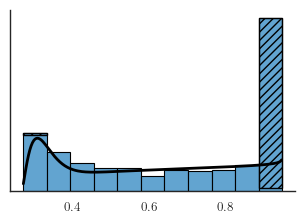

Converged at iteration 660
Converged at iteration 2876


100%|██████████| 1000/1000 [03:35<00:00,  4.65it/s]


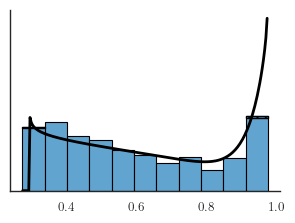

Converged at iteration 8119
Converged at iteration 510


100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]


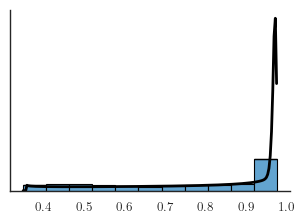

Converged at iteration 409
Converged at iteration 1964


100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]


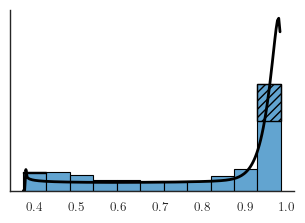

In [78]:
### Fit the probabilistic model for the marginal distribution

from matplotlib import rcParams
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from niagara.probabilistic_modeling.marginals import lumpy_betamix

# Enable LaTeX text rendering in Matplotlib
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['font.size'] = 10

pvals = {}
pvals_refitted = {}

SKIP_CVM = False
SKIP_CVM_REFITTED = False
REG = 0.0

params = {}

for MODEL_ID in range(len(CHAIN.model_names)):
    # Fit the marginal distribution to the TRAINING DATA
    marginal_params = lumpy_betamix.fit(np.array(calibrated_conf_train[MODEL_ID]), betamix_reg=REG)
    marginal_dist = lumpy_betamix(*marginal_params)

    # Get the calibrated confidence values for the TEST DATA, based on calibration trained on TRAINING data
    data = calibrated_conf_test[MODEL_ID]
    MODEL_NAME = CHAIN.model_names[MODEL_ID]
    SHORT_MODEL_NAME = MODEL_NAME.split("-")[-1]

    # Record the distributional parameters
    params_train = marginal_params
    # fit the marginal distribution on the test data to see how the params change
    marginal_params_test = lumpy_betamix.fit(np.array(data), betamix_reg=REG)
    marginal_dist_refitted = lumpy_betamix(*marginal_params_test)
    params_test = marginal_params_test
    params[MODEL_NAME] = { 'params_train': marginal_params, 'params_test': marginal_params_test }

    # Compute CVM test
    if not SKIP_CVM:
        empirical_cdf = ECDF(data)
        cvm_test_statistic = compute_cvm(empirical_cdf, marginal_dist.cdf)
        cvm_pval, cvm_statistic_list = compute_cvm_pval(cvm_test_statistic, marginal_dist, len(data))
        pvals[MODEL_NAME] = pvals[MODEL_NAME] | {
            'cvm': cvm_test_statistic,
            'cvm_pval': cvm_pval,
            'null_cvm_values': cvm_statistic_list
        }

    # Compute CVM test on refitted dist
    if not SKIP_CVM_REFITTED:
        empirical_cdf = ECDF(data)
        cvm_test_statistic = compute_cvm(empirical_cdf, marginal_dist_refitted.cdf)
        cvm_pval, cvm_statistic_list = compute_cvm_pval(cvm_test_statistic, marginal_dist_refitted, len(data))
        pvals_refitted[MODEL_NAME] = pvals_refitted[MODEL_NAME] | {
            'cvm': cvm_test_statistic,
            'cvm_pval': cvm_pval,
            'null_cvm_values': cvm_statistic_list
        }

    # Set a professional style
    sns.set_style("white")
    sns.set_context("paper", font_scale=1.0)

    fig, ax = plt.subplots(figsize=(3.5, 2.5))

    # Plot histogram using Seaborn's histplot (available in seaborn >= 0.11)
    sns.histplot(data, bins='auto', stat='density', kde=False, color="#2E86C1", edgecolor="black", ax=ax)

    counts, edges = np.histogram(data, bins='auto', density=False)
    mass_min_edges = edges[:2]
    mass_max_edges = edges[-2:]

    # grid for evaluating marginal_pdf
    grid = np.linspace(mass_min_edges[0]+1e-3,mass_max_edges[-1]-2e-3,200)
    # grid = np.linspace(0,1,200)
    marginal_pdf = marginal_dist.pdf(grid)

    # get the normalization factor of the histogram
    h = edges[1]-edges[0]
    n_bins = len(counts)
    total_counts = sum(counts)
    avg_count = total_counts/n_bins
    hist_integral = h*n_bins*avg_count

    first_bar_height = counts[0]/hist_integral
    last_bar_height = counts[-1]/hist_integral

    # compute multiplier for showing discrete mass on top of pdf
    w_multiplier = total_counts/hist_integral
    p_min, p_max, w_min, w_max, _, _, _, _, _ = params_train

    for edges, w, xmin_bar, total_bar_height in [
            (mass_min_edges, w_min, mass_min_edges[0], first_bar_height), 
            (mass_max_edges, w_max, mass_max_edges[0], last_bar_height)
        ]:
        w = w*w_multiplier
        
        rect = patches.Rectangle((xmin_bar, max(total_bar_height-w, 0)), 
                        width=edges[1]-edges[0], 
                        height=w,
                        facecolor='none',
                        edgecolor='black',
                        hatch='////',
                        linewidth=1.0,
                        alpha=1.0)
        plt.gca().add_patch(rect)

    # Add labels and title if desired
    ax.set_xlabel(r"\textbf{Calibrated Confidence}", fontsize=10)
    ax.set_ylabel(r"\textbf{Count}", fontsize=10)

    # Remove top and right spines for a cleaner look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Tight layout for better spacing
    plt.tight_layout()

    # Save as PDF (vector graphics)
    plt.plot(grid, marginal_pdf, color="black", linewidth=2.0)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_yticks([])

    plt.show()